forked from：
https://www.kaggle.com/dextrousjinx/brief-insight-on-web-traffic-time-series

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import calendar

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from bokeh.charts import TimeSeries, show

### File Size 获取文件大小

In [2]:
for f in os.listdir('../input'):
    size_bytes = round(os.path.getsize('../input/' + f)/ 1000, 2)
    size_name = ["KB", "MB"]
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    print(f.ljust(25) + str(s).ljust(7) + size_name[i])
    # ljuist是字符填充，用来保证打印出的结果对齐

key_1.csv                727.99 MB
sample_submission_1.csv  127.5  MB
train_1.csv              271.5  MB


In [3]:
train_df = pd.read_csv("../input/train_1.csv")
key_df = pd.read_csv("../input/key_1.csv")

In [4]:
print("Train".ljust(15), train_df.shape)
print("Key".ljust(15), key_df.shape)

Train           (145063, 551)
Key             (8703780, 2)


In [5]:
print(train_df[:4].append(train_df[-4:], ignore_index=True))
# 打印前四行和后四行

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  Resident_Evil:_Capítulo_Final_es.wikipedia.org...         NaN         NaN   
5  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...         NaN         NaN   
6  Hasta_el_último_hombre_es.wikipedia.org_all-ac...         NaN         NaN   
7  Francisco_el_matemático_(serie_de_televisión_d...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.

In [6]:
print(key_df[:4].append(key_df[-4:], ignore_index=True))
# page和id的关系

                                                Page            Id
0  !vote_en.wikipedia.org_all-access_all-agents_2...  bf4edcf969af
1  !vote_en.wikipedia.org_all-access_all-agents_2...  929ed2bf52b9
2  !vote_en.wikipedia.org_all-access_all-agents_2...  ff29d0f51d5c
3  !vote_en.wikipedia.org_all-access_all-agents_2...  e98873359be6
4  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  2489963dc503
5  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  b0624c909f4c
6  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  24a1dfb06c10
7  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  add681d54216


page name按照 'name_project_access_agent' 排列，可以将其分开成新的表

In [7]:
page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]
page_details.describe()
# 对于每个page，将其分开得到列，切分掉name，留下3列

,project,access,agent
count,145063,145063,145063
unique,9,3,2
top,en.wikipedia.org,all-access,all-agents
freq,24108,74315,110150


通过decribe可以发现，project，access和agent列中的取值分别只有9,3,2个，所以可以将其打印出来看看内容

In [8]:
project_columns = page_details['project'].unique()
access_columns = page_details['access'].unique()
agents_columns = page_details['agent'].unique()
print(list(page_details['project'].unique()))
print(list(page_details['access'].unique()))
print(list(page_details['agent'].unique()))

['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org', 'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org', 'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org']
['all-access', 'desktop', 'mobile-web']
['spider', 'all-agents']


确认没有缺失值过后，将其merge进入原来的表中

In [9]:
train_df = train_df.merge(page_details, how="inner", left_index=True, right_index=True)

按照类的值绘制平均浏览量

In [16]:
def graph_by(plot_hue, graph_columns):
    train_project_df = train_df.groupby(plot_hue).sum().T
    print("train_project_df",train_project_df.head())
    # 分组，求和，转置
    train_project_df.index = pd.to_datetime(train_project_df.index)
    # pd可以自动将stringde时间转化为year， mouth 的等字段
    print(train_project_df.index)
    train_project_df = train_project_df.groupby(pd.TimeGrouper('M')).mean().dropna()
    # 按照月份平均值进行group
    print("train_project_df",train_project_df.head())
    train_project_df['month'] = 100*train_project_df.index.year + train_project_df.index.month
    # 将月份变为int形式
    train_project_df = train_project_df.reset_index(drop=True)
    print("train_project_df",train_project_df.head())
    train_project_df = pd.melt(train_project_df, id_vars=['month'], value_vars=graph_columns)
    print("train_project_df",train_project_df.head())
    fig = plt.figure(1,figsize=[12,10])
    ax = sns.pointplot(x="month", y="value", hue=plot_hue, data=train_project_df)
    ax.set(xlabel='Year-Month', ylabel='Mean Hits')

train_project_df project     commons.wikimedia.org  de.wikipedia.org  en.wikipedia.org  \
2015-07-01              1140821.0        13260519.0        84712190.0   
2015-07-02              1178130.0        13079896.0        84438545.0   
2015-07-03              1150547.0        12554042.0        80167728.0   
2015-07-04               951317.0        11520379.0        83463204.0   
2015-07-05              1058036.0        13392347.0        86198637.0   

project     es.wikipedia.org  fr.wikipedia.org  ja.wikipedia.org  \
2015-07-01        15278553.0         8458638.0        11863200.0   
2015-07-02        14601013.0         8512952.0        13620792.0   
2015-07-03        13427632.0         8186030.0        12305383.0   
2015-07-04        12606538.0         8749842.0        15456239.0   
2015-07-05        13710356.0         8590493.0        14827204.0   

project     ru.wikipedia.org  www.mediawiki.org  zh.wikipedia.org  
2015-07-01         9463854.0           349713.0         4144988.0  

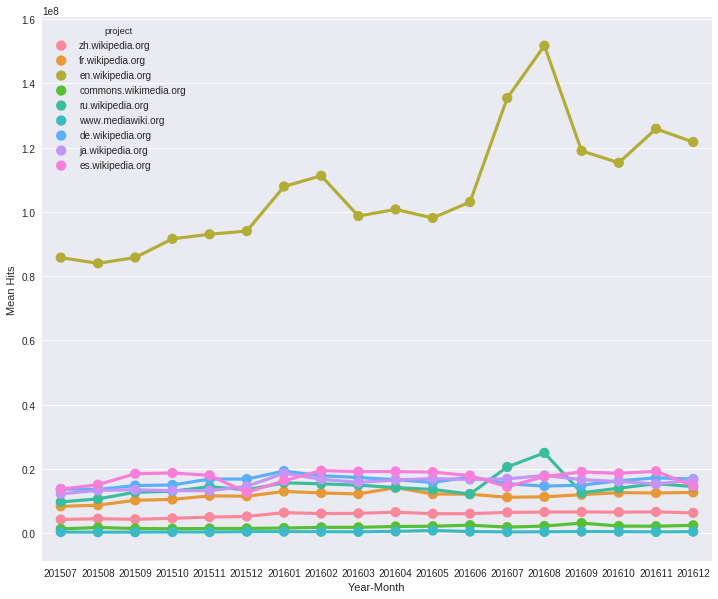

In [17]:
graph_by("project", project_columns)

将英文wiki和其他图分开，由于英文wiki在i=2的位置，可以采用enumerate+条件的方式

train_project_df project     commons.wikimedia.org  de.wikipedia.org  en.wikipedia.org  \
2015-07-01              1140821.0        13260519.0        84712190.0   
2015-07-02              1178130.0        13079896.0        84438545.0   
2015-07-03              1150547.0        12554042.0        80167728.0   
2015-07-04               951317.0        11520379.0        83463204.0   
2015-07-05              1058036.0        13392347.0        86198637.0   

project     es.wikipedia.org  fr.wikipedia.org  ja.wikipedia.org  \
2015-07-01        15278553.0         8458638.0        11863200.0   
2015-07-02        14601013.0         8512952.0        13620792.0   
2015-07-03        13427632.0         8186030.0        12305383.0   
2015-07-04        12606538.0         8749842.0        15456239.0   
2015-07-05        13710356.0         8590493.0        14827204.0   

project     ru.wikipedia.org  www.mediawiki.org  zh.wikipedia.org  
2015-07-01         9463854.0           349713.0         4144988.0  

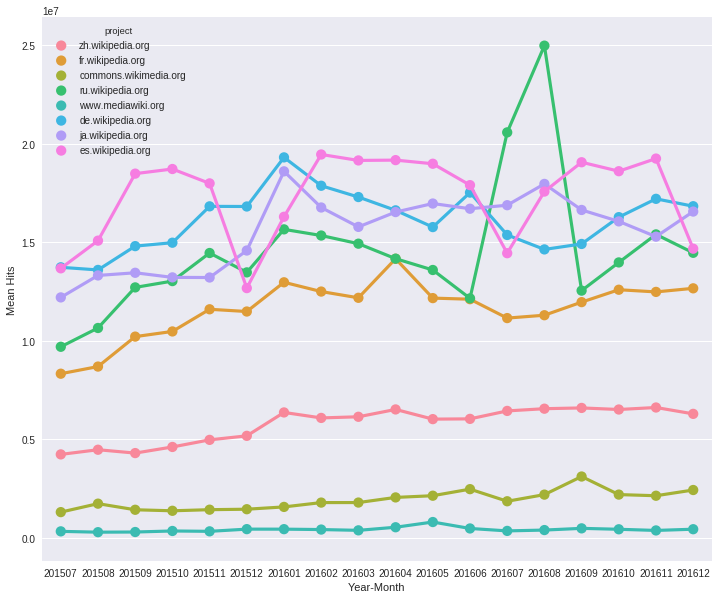

In [18]:
graph_by("project", [x for i,x in enumerate(project_columns) if i!=2])

同样，对于access和agent进行同样的可视化操作

train_project_df access      all-access     desktop  mobile-web
2015-07-01  74698113.0  39876738.0  34097625.0
2015-07-02  75607094.0  40166627.0  33820119.0
2015-07-03  71086918.0  35875973.0  34201307.0
2015-07-04  73484575.0  33600249.0  38528113.0
2015-07-05  76515131.0  35422879.0  39557362.0
DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=550, freq=None)
train_project_df access        all-access       desktop    mobile-web
2015-07-31  7.519721e+07  3.871641e+07  3.526896e+07
2015-08-31  7.644981e+07  3.937608e+07  3.590992e+07
2015-09-30  8.143823e+07  4.256735e+07  3.739676e+07
2015-10-31  8.527277e

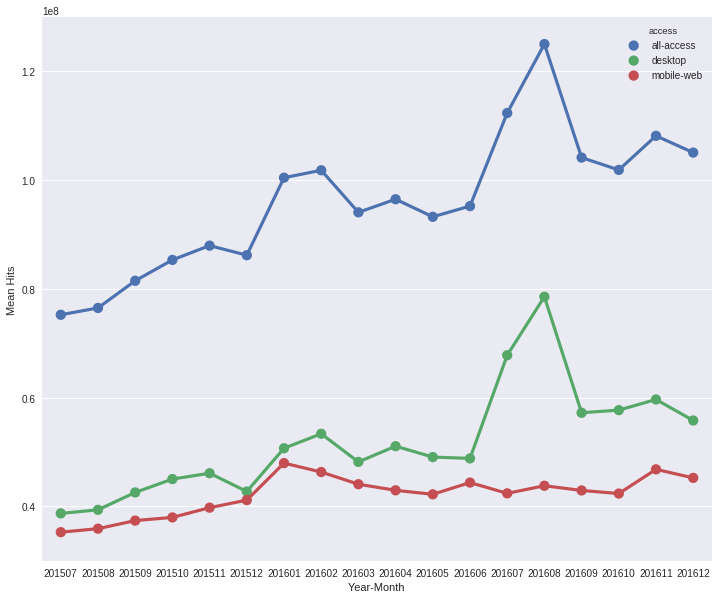

In [19]:
graph_by("access", access_columns)

train_project_df agent        all-agents    spider
2015-07-01  148007828.0  664648.0
2015-07-02  148974290.0  619550.0
2015-07-03  140569096.0  595102.0
2015-07-04  144999076.0  613861.0
2015-07-05  150873028.0  622344.0
DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=550, freq=None)
train_project_df agent         all-agents        spider
2015-07-31  1.484898e+08  6.928089e+05
2015-08-31  1.510346e+08  7.011544e+05
2015-09-30  1.602028e+08  1.199570e+06
2015-10-31  1.660281e+08  2.245944e+06
2015-11-30  1.719206e+08  1.835397e+06
train_project_df agent    all-agents        spider   month
0      1.484898e+0

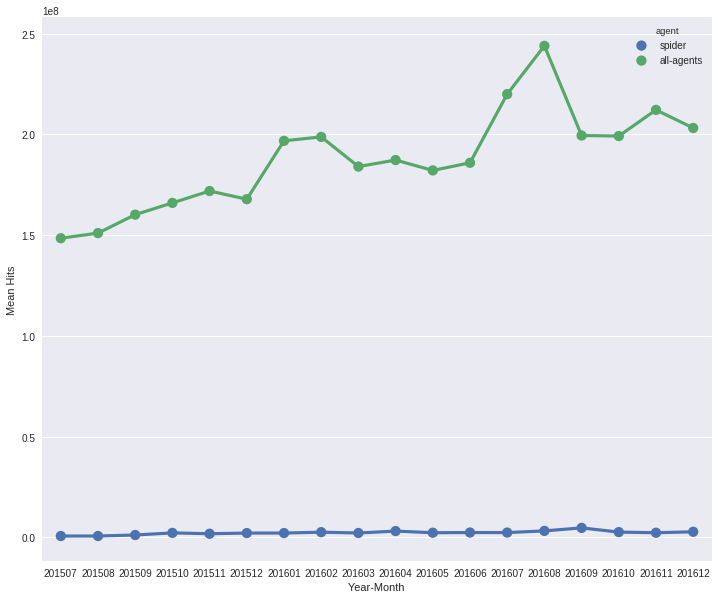

In [20]:
graph_by("agent", agents_columns)

同样地，将两种数据分开绘制

train_project_df agent        all-agents    spider
2015-07-01  148007828.0  664648.0
2015-07-02  148974290.0  619550.0
2015-07-03  140569096.0  595102.0
2015-07-04  144999076.0  613861.0
2015-07-05  150873028.0  622344.0
DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=550, freq=None)
train_project_df agent         all-agents        spider
2015-07-31  1.484898e+08  6.928089e+05
2015-08-31  1.510346e+08  7.011544e+05
2015-09-30  1.602028e+08  1.199570e+06
2015-10-31  1.660281e+08  2.245944e+06
2015-11-30  1.719206e+08  1.835397e+06
train_project_df agent    all-agents        spider   month
0      1.484898e+0

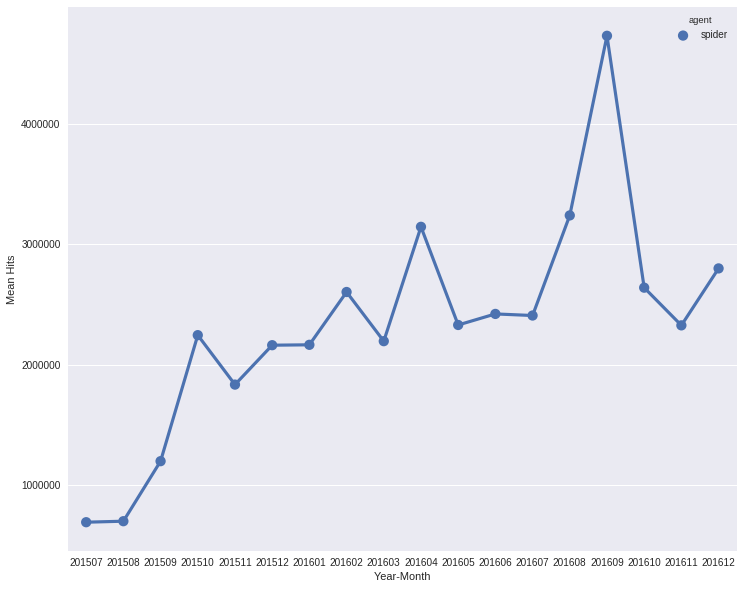

In [21]:
graph_by("agent", agents_columns[0])

train_project_df agent        all-agents    spider
2015-07-01  148007828.0  664648.0
2015-07-02  148974290.0  619550.0
2015-07-03  140569096.0  595102.0
2015-07-04  144999076.0  613861.0
2015-07-05  150873028.0  622344.0
DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=550, freq=None)
train_project_df agent         all-agents        spider
2015-07-31  1.484898e+08  6.928089e+05
2015-08-31  1.510346e+08  7.011544e+05
2015-09-30  1.602028e+08  1.199570e+06
2015-10-31  1.660281e+08  2.245944e+06
2015-11-30  1.719206e+08  1.835397e+06
train_project_df agent    all-agents        spider   month
0      1.484898e+0

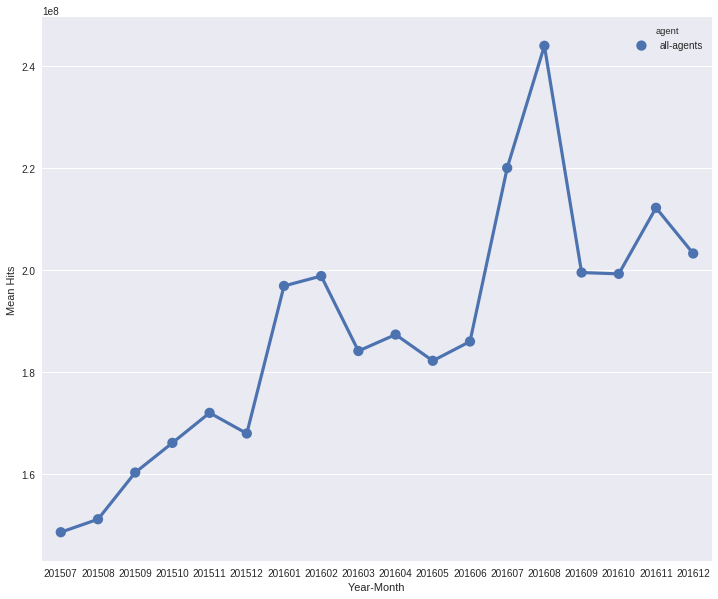

In [22]:
graph_by("agent", agents_columns[1])